# `SyntheticGenerator` tutorial

This tutorial demonstrates how to generate synthetic seismic along with horizons and faults using `seismiqb`. One can use generated data for training models for horizon/faults detaction as well as testing purposes.

By the end of the tutorial you will know two ways of generating synthetic data:
- chaining methods from `SyntheticGenerator`-class
- running `generate_synthetic`-wrapper function

In [66]:
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from synthetic import generate_synthetic, SyntheticGenerator

## Using `SyntheticGenerator`-class

In order to create synthetic seismic using `SyntheticGenerator`-class one must chain methods for

- generation of a range of velocities
- generation of velocity-model
- adding faults (optionaly)
- making density-model
- generation synthetic-model
- postprocessing synthetic model (optinally)

from a class instance. For reproducibility purposes `SyntheticGenerator`-instance can be initiated with a seed:

In [78]:
gen = SyntheticGenerator(seed=100)

In [79]:
%%time
gen = (gen.make_velocities(num_reflections=80,
                           horizon_heights=(0.2, 0.3, 0.5, 0.8),
                           horizon_multipliers=(-8, 8, -7, 9))
          .make_velocity_model((200, 800), (10, ))
          .add_faults(faults_coordinates=(((100, 100), (120, 220)),
                                          ((150, 600), (200, 720))),
                      zeros_share=0.4)
          .make_density_model()
          .make_synthetic()
          .postprocess_synthetic(noise_mul=0.2))

CPU times: user 59 ms, sys: 7.49 ms, total: 66.5 ms
Wall time: 63.7 ms


check out generated synthetic along with corresponding velocity-model

Text(0.5, 1.0, 'Velocity model')

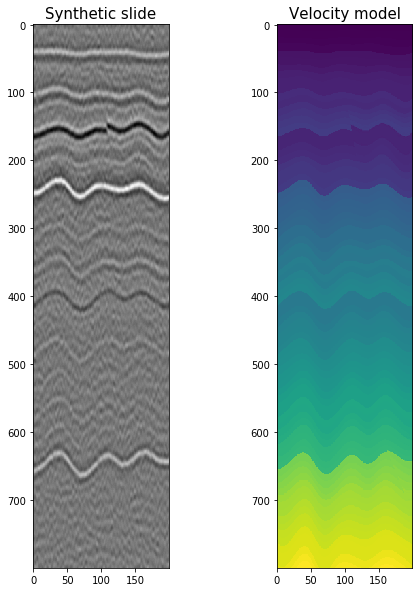

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(8, 10))
ax[0].imshow(gen.synthetic.T, cmap=plt.cm.gray)
ax[0].set_title('Synthetic slide', fontsize=15)
ax[1].imshow(gen.velocity_model.T, cmap=plt.cm.viridis)
ax[1].set_title('Velocity model', fontsize=15)

## Using `generate_synthetic`-wrapper

a bit simpler way involves using `generate_synthetic`-wrapper function:

In [77]:
%%time
synt2d, _, _ = generate_synthetic(shape=(200, 800), grid_shape=10, num_reflections=80,
                                  horizon_heights=(0.2, 0.3, 0.5, 0.8),
                                  horizon_multipliers=(-8, 8, -7, 9),
                                  faults_coordinates=(((100, 100), (120, 220)),
                                                      ((150, 600), (180, 720))),
                                  zeros_share_faults=0.2, seed=100,
                                  noise_mul=0.2,
                                 )

CPU times: user 58.4 ms, sys: 7.66 ms, total: 66.1 ms
Wall time: 65.4 ms


Text(0.5, 1.0, 'Synthetic slide')

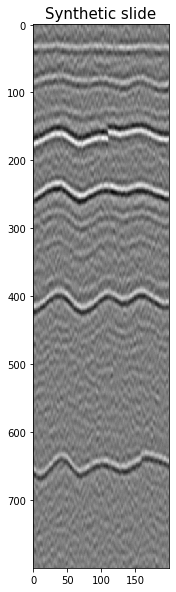

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(synt2d.T, cmap=plt.cm.gray)
ax.set_title('Synthetic slide', fontsize=15)

## Creating a synthetic cube; `dump` and `load` it with `seismiqb`

Naturally, one can `dump` a created cube and `load` it in a usual way using `seismiqb`:

In [81]:
sys.path.append('../../../')
from seismiqb.src.geometry.export import make_segy_from_array
from seismiqb.batchflow import Pipeline, Dataset, DatasetIndex, FilesIndex
from seismiqb import Horizon, Field, SeismicDataset

In [82]:
%%time
synt3d, hors, _ = generate_synthetic(shape=(150, 150, 200), grid_shape=(10, 10),
                                     num_reflections=60,
                                     geobodies_format=('heights', 'mask'))

CPU times: user 563 ms, sys: 111 ms, total: 674 ms
Wall time: 679 ms


* dumping created cube

In [83]:
%%time
make_segy_from_array(synt3d, 'cube_test.sgy', zip_segy=False)

/Users/aleksandr/opt/anaconda3/lib/python3.7/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)



CPU times: user 1.33 s, sys: 482 ms, total: 1.81 s
Wall time: 1.71 s


* dumping horizons

In [84]:
field = Field('./cube_test.sgy')

Finding min/max: 100%|█████████████████| 22500/22500 [00:00<00:00, 46859.66it/s]


In [85]:
import os
from glob import glob

In [86]:
horizons = [Horizon(hor, field, 'synthetic_' + str(i)) for i, hor in enumerate(hors)]

In [87]:
if not os.path.exists('./test_horizons'):
    os.mkdir('./test_horizons')
for i, horizon in enumerate(horizons):
    horizon.dump('./test_horizons/hor_{}.txt'.format(i))

* using `seismiqb` to load it all

In [88]:
cubes = {'./cube_test.sgy': './test_horizons/*'}
ds = SeismicDataset(cubes, labels_class='horizon', collect_stats=True)

../../../seismiqb/src/plotters.py:356: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/aleksandr/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


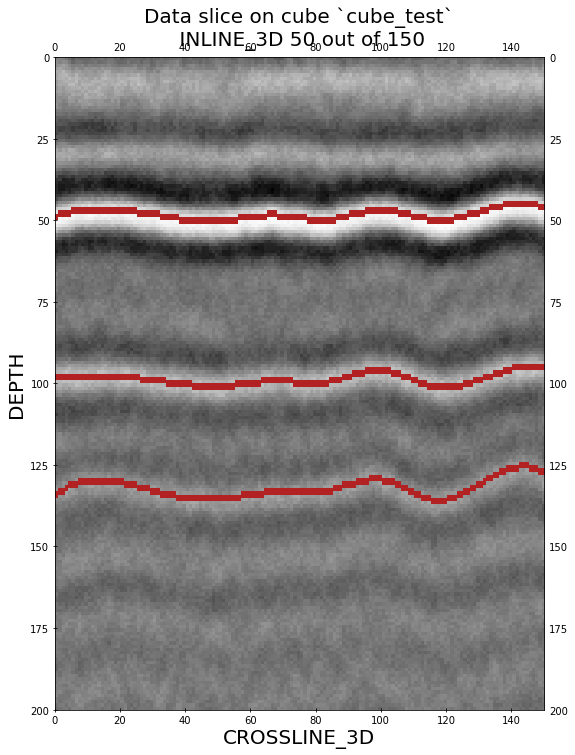

In [89]:
ds.show_slide(50)

* remove everything

In [90]:
import shutil

In [91]:
for path in ['./cube_test.meta', './cube_test.sgy', './test_horizons/', './CUBE_INFO.log']:
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)
        else:
            shutil.rmtree(path)